# Notebook to test methods for extracting kinematics from highspeed video

## Imports

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.util import invert, img_as_float
import skimage.morphology  as morphology
from skimage.segmentation import clear_border

from mosquito.read_photron import my_read_cih, my_read_mraw


## Set params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


## Load data

In [4]:
# path to data files
# paths to data
data_root = '/media/sam/SamData/Mosquitoes'
data_folder = '16_20240506'  # '17_20240507' # '05_20240322'  #'08_20240401' # '04_20240321' #   '05_20240322'  # '03_20240319' # 
axo_num = 1

data_path = os.path.join(data_root, data_folder, '*_{:04d}'.format(axo_num))
vid_path_full = glob.glob(os.path.join(data_path, '*/*.mraw'))[0]
vid_path_full


'/media/sam/SamData/Mosquitoes/16_20240506/2024_05_06_0001/aedes_C001H001S0001_20240506_152928/aedes_C001H001S0001_20240506_152928.mraw'

In [5]:
# read video -- only some of the frames
frames = (0, 500)
imgs, metadata = my_read_mraw(vid_path_full, frames=frames)


/home/sam/Documents/code/mosquito/src/mosquito/read_photron.py:179: UserWarning: Clipped footage! (Total frame: 12476, Orig. total frame: 13973)
  warnings.warn('Clipped footage! (Total frame: {}, Orig. total frame: {})'.format(cih['Total Frame'],


Reading /media/sam/SamData/Mosquitoes/16_20240506/2024_05_06_0001/aedes_C001H001S0001_20240506_152928/aedes_C001H001S0001_20240506_152928.mraw
PFV 12-bit MRAW
File contains 12476 frames (640 x 640)
Reading frames 0 to 500
Read 292.0 MiB in 3.1 sec
	Data in memory:	 (500, 640, 640)
	Intensity range:	 0 to 3900 	 uint16
	Array size:	390.6 MB


In [6]:
imgs.shape

(500, 640, 640)

## Binarize images
I think our lighting conditions are good enough where this won't be a problem

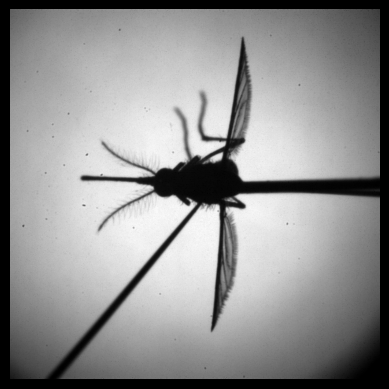

In [7]:
# look at a frame
fig, ax = plt.subplots()

ax.imshow(imgs[0,:,:], cmap='grey')
ax.set_axis_off()


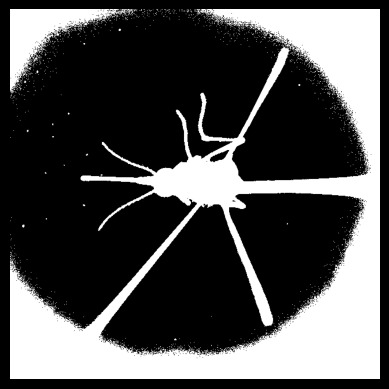

In [47]:
# try simple binarization
image = invert(imgs[10])
# image = exposure.equalize_hist(image)

threshold = threshold_otsu(image)
bw = image > threshold

# visualize
fig, ax = plt.subplots()
ax.imshow(bw, cmap='grey')
ax.set_axis_off()


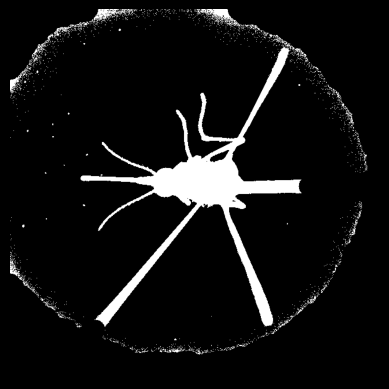

In [48]:
# probably want to erode this to remove stuff around edges
erode_rad = 12
dilate_rad = erode_rad + 5

bw2 = morphology.isotropic_erosion(bw, erode_rad)
bw3 = clear_border(bw2)
bw4 = bw2 & ~bw3
bw4 = morphology.isotropic_dilation(bw4, dilate_rad)
bw5 = np.asarray(~bw4)*bw

# visualize
fig, ax = plt.subplots()
ax.imshow(bw5, cmap='grey')
ax.set_axis_off()

In [65]:
# # try to remove uneven lighting in background
# image = img_as_float(image)
# h = 0.4
# seed = image - h
# dilated = morphology.reconstruction(seed, image, method='dilation')
# hdome = image - dilated

# # visualize
# fig, ax = plt.subplots()
# ax.imshow(hdome, cmap='grey')
# ax.set_axis_off()



In [59]:
# open image to remove remaining border noise
bw6 = morphology.binary_opening(bw5,

327679.99999999994

## Detect wings

I think I can extract the wings by looking at pixels that change from frame to frame (ala fly code from Cohen Lab). Probably a simple threshold will get body, but have to separate tether from that